# Forecasting Hourly based energy consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [2]:
url = '../input/hourly-energy-consumption/PJME_hourly.csv'
df = pd.read_csv(url)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


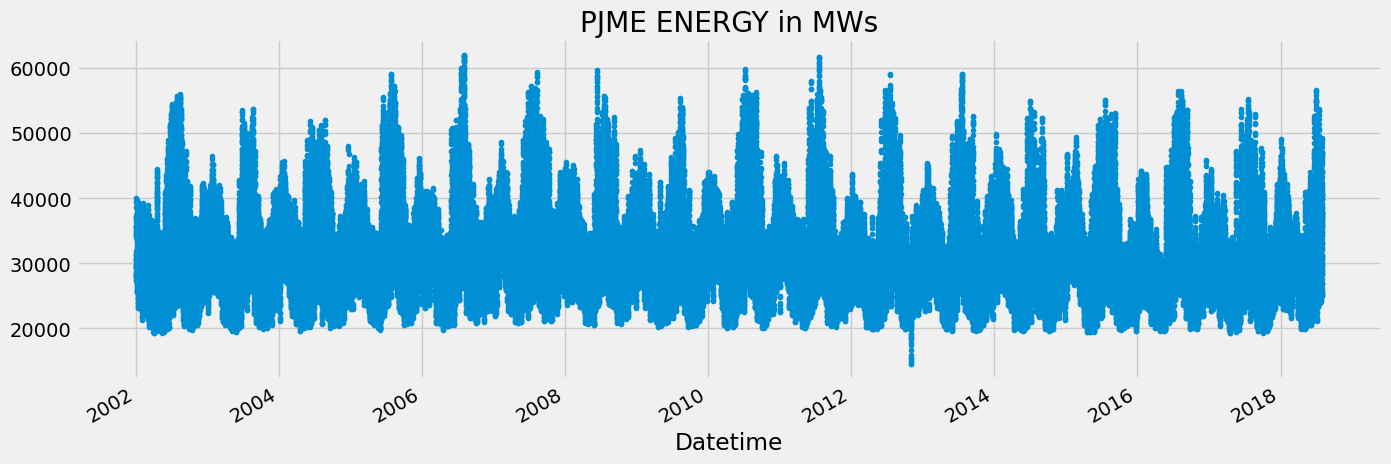

In [4]:
df.plot(style='.', figsize=(15,5),
        color=color_pal[0],
        title='PJME ENERGY in MWs', legend=False)
plt.show()

## Train/Test Split

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index > '01-01-2015']

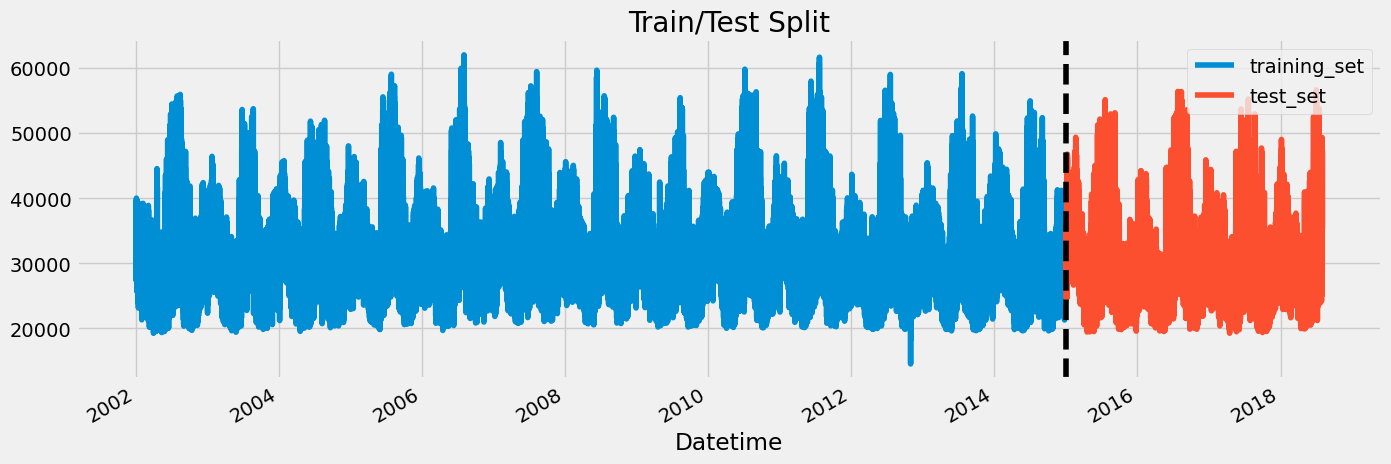

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, title = 'Train/Test Split', label='train_MWs')
test.plot(ax=ax, label='Test_MWs')
ax.axvline('01-01-2015', color = 'black', ls='--')
ax.legend(['training_set', 'test_set'])

plt.show()

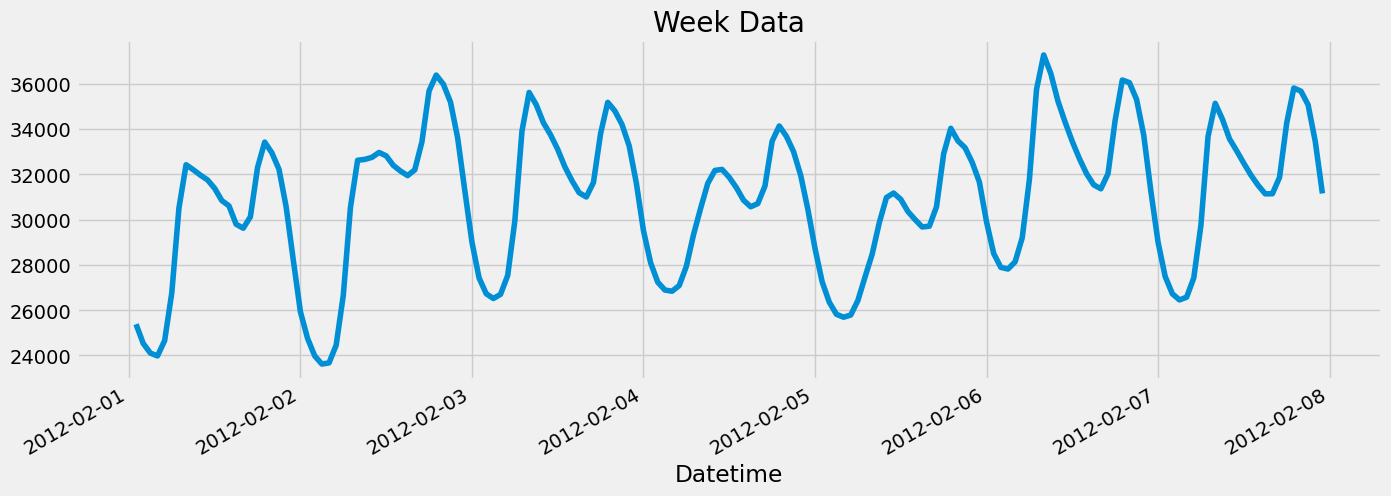

In [7]:
df.loc[(df.index > '02-01-2012') & (df.index < '02-08-2012')].plot(figsize=(15,5), title='Week Data', legend=False)
plt.show()

## Feature Creation

In [8]:
def create_features(df):
    '''
    Create time series features using time series index. 
    '''
    
    df = df.copy()
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Dayofyear'] = df.index.dayofyear
    return df

In [9]:
df = create_features(df)
df.head()

,PJME_MW,Hour,DayOfWeek,Quarter,Month,Year,Dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


## Visualize features

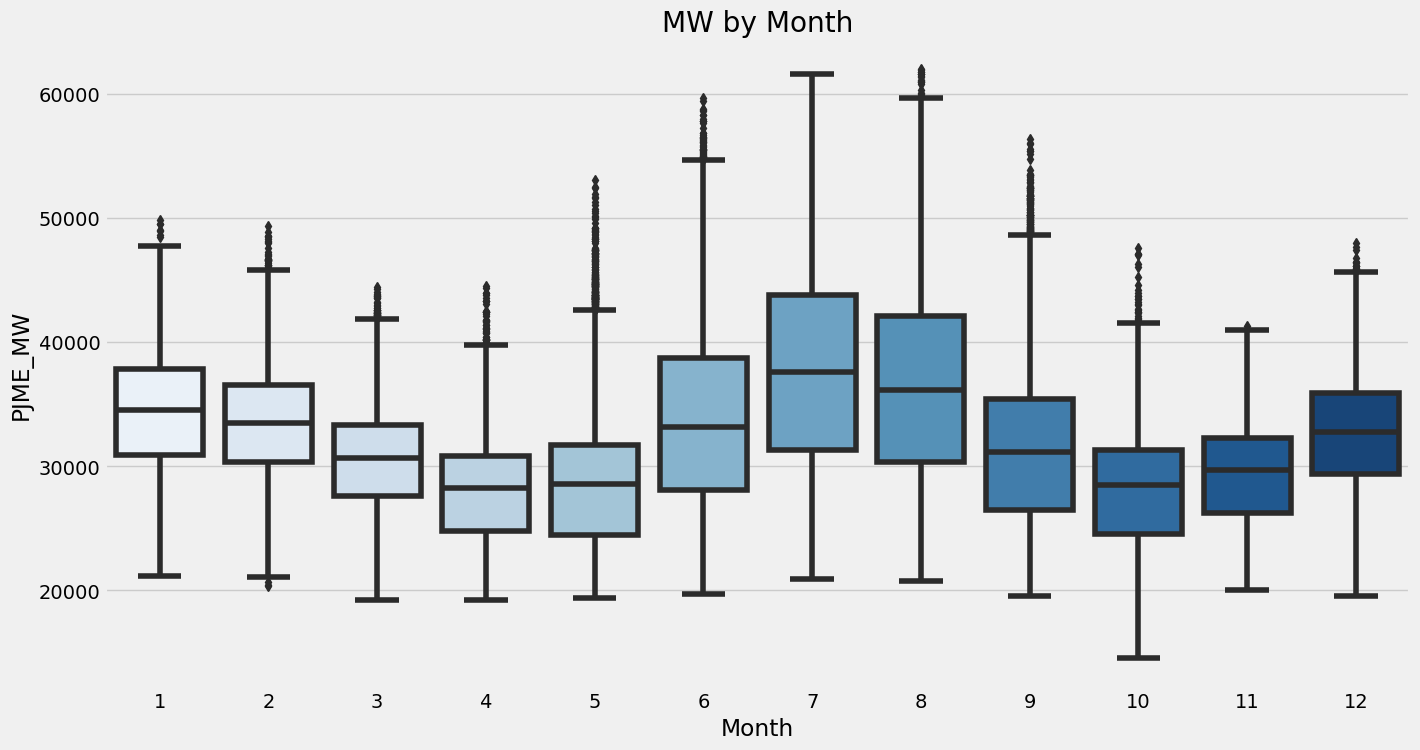

In [10]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df, x='Month', y='PJME_MW',palette='Blues')
ax.set_title('MW by Month')
plt.show()

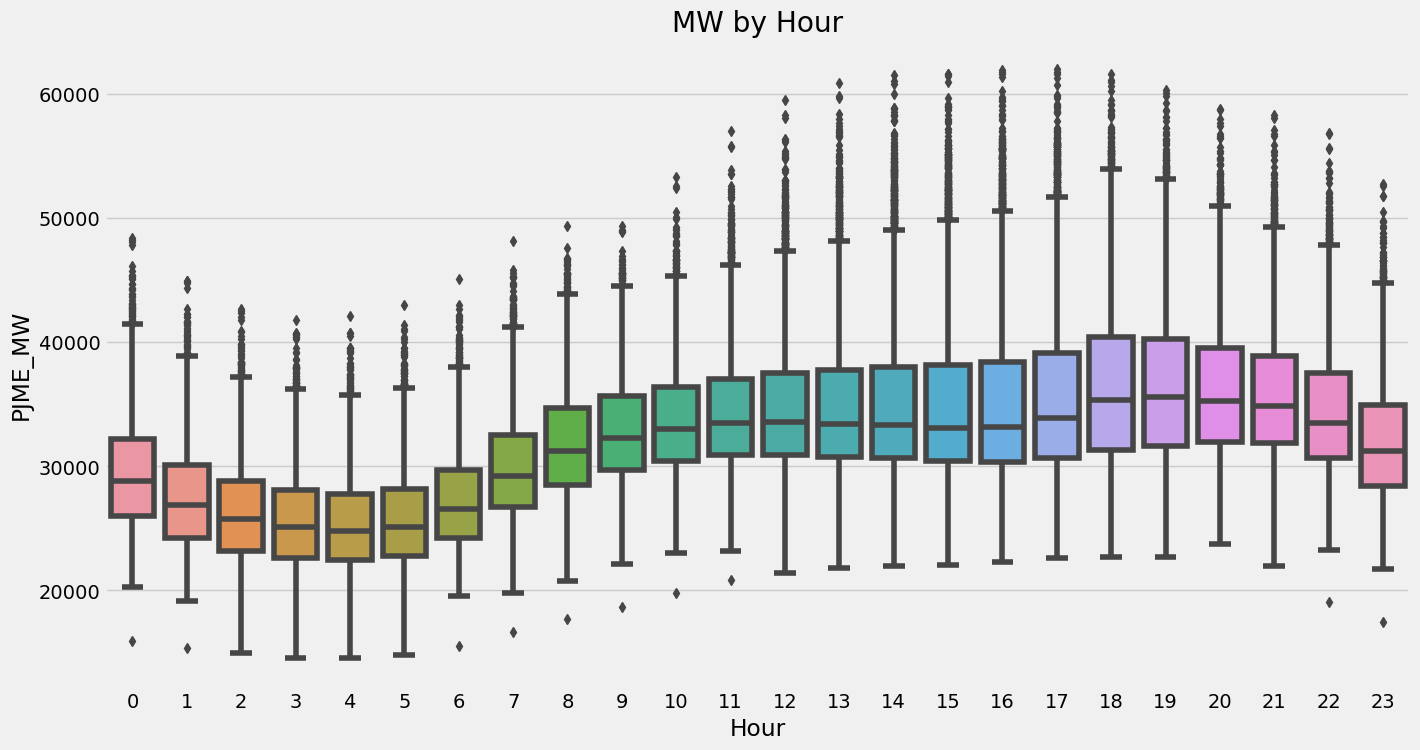

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df, x='Hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

## Create Model

In [12]:
train = create_features(train)
test = create_features(test)

feature = ['Hour', 'DayOfWeek', 'Quarter', 'Month', 'Year', 'Dayofyear']
target = ['PJME_MW']

In [13]:
x_train = train[feature]
y_train = train[target]

In [14]:
x_test = test[feature]
y_test = test[target]

In [15]:
regression_m = xgb.XGBRegressor(n_estimate=1000, early_stopping_round=50, learning_rate=0.001)
regression_m.fit(x_train, y_train,
                eval_set = [(x_train, y_train), (x_test, y_test)],
                verbose=100)

[09:30:29] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stopping_round", "n_estimate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32894.63731	validation_1-rmse:31946.74695
[99]	validation_0-rmse:29831.80181	validation_1-rmse:28879.79287


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_round=50, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimate=1000, n_estimators=100, n_jobs=0, num_parallel_tree=1,
             predictor='auto', random_state=0, ...)

## Feature Importance

In [16]:
fi = pd.DataFrame(data=regression_m.feature_importances_,
                  index=regression_m.feature_names_in_,
                  columns=['Importance'])

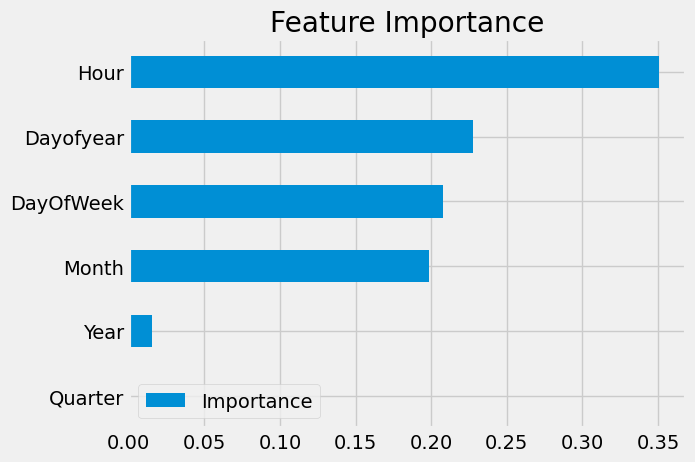

In [17]:
fi.sort_values(['Importance']).plot(kind='barh', title='Feature Importance')
plt.show()